In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import List

In [2]:
df = pd.read_excel('../شستا.xlsx', parse_dates=True, index_col='Date')

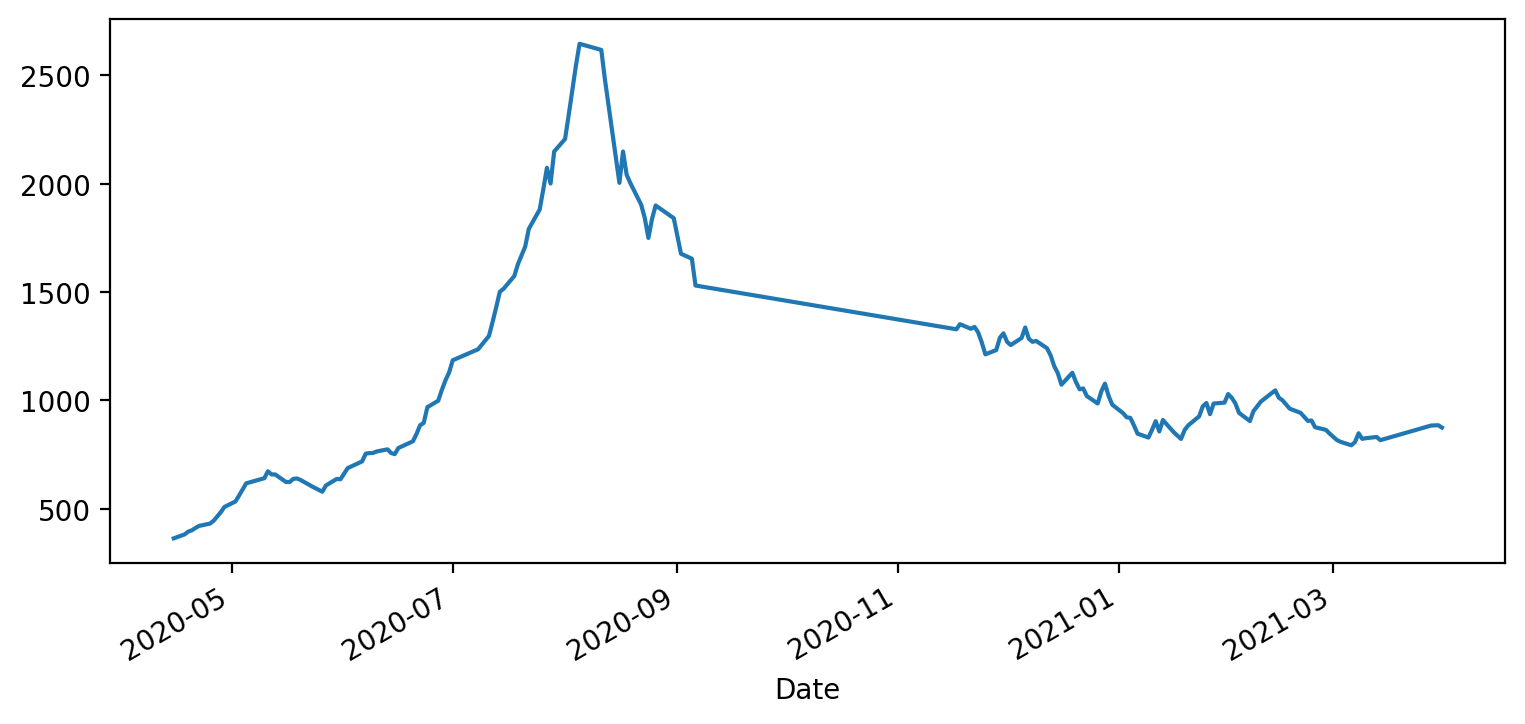

In [3]:
df = pd.read_excel('../شستا.xlsx', parse_dates=True, index_col='Date')['Adj Close']
df1 = df[:'2021-3']
plt.figure(figsize=(9,4), dpi=200)
df1.plot()
plt.show()

In [4]:
class Node:
    """ Define Salient Points

    Attributes:
    ===========

    time: It stores the time stamp of a salient point

    value: It stores the price (closing price) for financial time series

    dist: Distance, such as VD, ED or PD

    ssp: Segment start point

    sep: Segment end point

    spr: Salient point rank. The initial value is 0

    l_child: The left child

    r_child: The right child
    """

    def __init__(self, time, value, dist, ssp, sep):
        self.time = time
        self.value = value
        self.dist = dist
        self.ssp = ssp
        self.sep = sep
        self.spr = 0
        self.l_child = None
        self.r_child = None

In [5]:
class Tree:
    """ Construct PIP Binary Tree

    Attributes:
    ==========

    p: The time series which its PIPs must be detected

    n: The number of PIPs

    start: start of window

    end: end of window

    root: root of the tree

    important_nodes_time: list of PIP's times

    zeros_list: list of nodes which have zeros spr
    """
    def __init__(self, p, n, start, end):
        self.p = p
        self.n = n
        self.start = start
        self.end = end
        self.root = None
        self.important_nodes_time = [self.start, self.end]
        self.zeros_list = []

    # calculate vertical distance of each point based on start and end of segment
    def vertical_dist(self, ssp, sep, sp):
        dist = np.abs(self.p.iloc[ssp]
                      - self.p.iloc[sp]
                      + (self.p.iloc[sep] - self.p.iloc[ssp])*(sp - ssp)/(sep - ssp))
        return dist

    # find salient point at each segment
    def salient_point(self, ssp, sep):
        # distance & idx of salient point
        sp_dist = 0
        sp_idx = 0

        for i in np.arange(ssp+1,sep):
            if self.vertical_dist(ssp, sep, i) > sp_dist:
                sp_dist = self.vertical_dist(ssp, sep, i)
                sp_idx = i

        return sp_idx, sp_dist

    # return distance value of each node
    @staticmethod
    def ret_dist(node):
        return node.dist

    def create_children(self, parent):
        # create left child
        sp_idx, sp_dist = self.salient_point(parent.ssp, parent.time)
        parent.l_child = Node(sp_idx, self.p.iloc[sp_idx], sp_dist, parent.ssp, parent.time)
        #create right child
        sp_idx, sp_dist = self.salient_point(parent.time, parent.sep)
        parent.r_child = Node(sp_idx, self.p.iloc[sp_idx], sp_dist, parent.time, parent.sep)

    def create_root(self):
        sp_idx, sp_dist = self.salient_point(self.start, self.end)
        self.root = Node(sp_idx, self.p.iloc[sp_idx], sp_dist, self.start, self.end)

    def child_to_zero_list(self, parent):
        self.zeros_list.extend([parent.l_child, parent.r_child])

    def next_spr(self):
        important_node = max(self.zeros_list, key=self.ret_dist)
        self.zeros_list.remove(important_node)
        return important_node

    # Build Perceptually Important Points Binary Tree
    def build_PIP(self):

        self.create_root()
        self.important_nodes_time.append(self.root.time)
        self.create_children(parent=self.root)
        self.child_to_zero_list(parent=self.root)

        # find other important nodes
        for spr in np.arange(2,self.n-1):
            important_node = self.next_spr()
            self.important_nodes_time.append(important_node.time)

            self.create_children(parent=important_node)
            self.child_to_zero_list(parent=important_node)

    # pruning a side of the tree
    def pruning(self, node, side='right'):

        if side == 'right':
            if node.r_child is None:
                return
            sp_idx, sp_dist = self.salient_point(node.time, self.end)
            if sp_idx == node.r_child.time:
                node.r_child.dist = sp_dist
                self.pruning(node.r_child)
            else:
                node.r_child = Node(sp_idx, self.p.iloc[sp_idx], sp_dist, node.time, node.sep)

        else:
            if node.l_child is None:
                return
            sp_idx, sp_dist = self.salient_point(self.start, node.time)
            if sp_idx == node.l_child.time:
                node.l_child.dist = sp_dist
                self.pruning(node.l_child, side='left')
            else:
                node.l_child = Node(sp_idx, self.p.iloc[sp_idx], sp_dist, node.ssp, node.time)

    def update_zeros_list(self, node):
        if node.l_child is not None:
            self.zeros_list.extend([node.l_child, node.r_child])
            self.update_zeros_list(node.l_child)
            self.update_zeros_list(node.r_child)

    # rebuild PIP_BTree for sliding window(shifting, expansion, shrinking)
    def update_PIP(self, update_sep, update_ssp=None):

        self.end = update_sep
        if update_ssp is not None:
            self.start = update_ssp

        self.important_nodes_time = [self.start, self.end]

        # check root
        sp_idx, sp_dist = self.salient_point(self.start, self.end)
        if sp_idx != self.root.time:
            self.build_PIP()
            return

        # update root
        self.root.dist = sp_dist
        self.root.ssp = self.start
        self.root.sep = self.end
        self.important_nodes_time.extend([self.root.time])

        # pruning the right side of tree
        self.pruning(self.root, side='right')
        # pruning the left side of tree
        if update_ssp is not None:
            self.pruning(self.root, side='left')

        # update zeros list
        self.zeros_list = []
        self.update_zeros_list(self.root)

        # regenerate & rerank tree's nodes
        for spr in np.arange(2, self.n-1):
            important_node = self.next_spr()
            self.important_nodes_time.append(important_node.time)

            if important_node.l_child is None:
                self.create_children(parent=important_node)
                self.child_to_zero_list(parent=important_node)


In [6]:
segment = Tree(df1, 8, 0, 91)

In [7]:
segment.build_PIP()

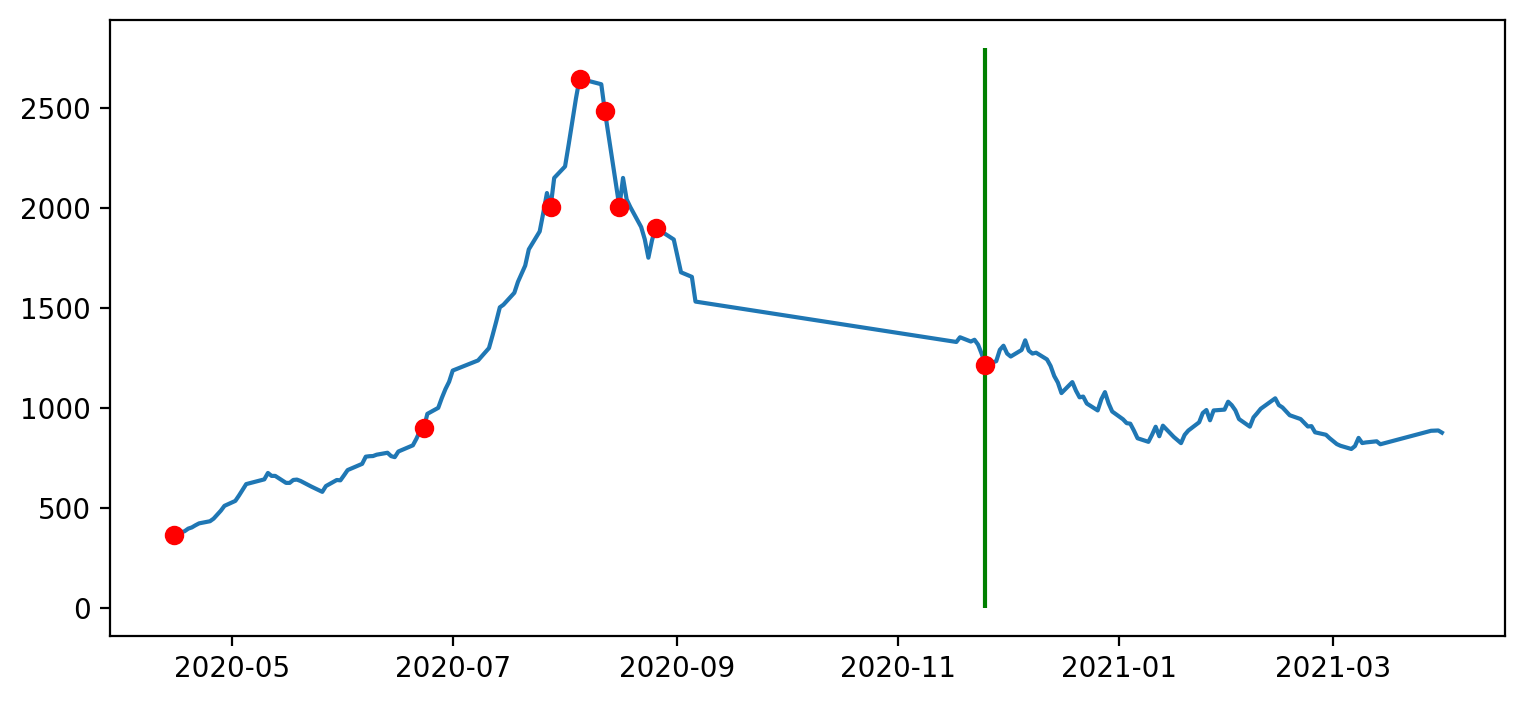

In [8]:
plt.figure(figsize=(9, 4), dpi=200)
plt.plot(df1)
plt.vlines(df1.index[91], 0, 2800, colors='green')
plt.plot(df1.index[segment.important_nodes_time], df1.iloc[segment.important_nodes_time], 'ro')
plt.show()

In [9]:
segment.update_PIP(update_ssp=42, update_sep=120)
segment.important_nodes_time

[42, 120, 68, 85, 71, 79, 70, 62]

In [10]:
shift_segment = Tree(df1, 8, 42, 120)
shift_segment.build_PIP()
shift_segment.important_nodes_time

[42, 120, 68, 85, 71, 79, 70, 62]

# Chart Pattern

In [9]:
class Pattern:

    def __init__(self, p: pd.DataFrame):
        self.p = p
        self.top_hs_time = []
        self.bottom_hs_time = []

    def minor_high(self, sp, i):
        if (self.p.iloc[sp[i]] > self.p.iloc[sp[i-1]]
                and self.p.iloc[sp[i]] > self.p.iloc[sp[i+1]]):
            return True
        else:
            return False

    def minor_low(self, sp, i):
        if (self.p.iloc[sp[i]] < self.p.iloc[sp[i-1]]
                and self.p.iloc[sp[i]] < self.p.iloc[sp[i+1]]):
            return True
        else:
            return False

    def major_high(self, sp, i):
        if (self.p.iloc[sp[i]] > self.p.iloc[sp[i-2]]
                and self.p.iloc[sp[i]] > self.p.iloc[sp[i+2]]):
            return True
        else:
            return False

    def major_low(self, sp, i):
        if (self.p.iloc[sp[i]] < self.p.iloc[sp[i-2]]
                and self.p.iloc[sp[i]] < self.p.iloc[sp[i+2]]):
            return True
        else:
            return False

    def similar_price(self, i, j, argmax, argmin):
        dif_i_j = np.abs(self.p.iloc[i] - self.p.iloc[j])
        dif_max_min = self.p.iloc[argmax] - self.p.iloc[argmin]

        if  dif_i_j < 0.1 * dif_max_min:
            return True
        else:
            return False

    @staticmethod
    def similar_time_interval(i, j, k, g, maxarg, minarg):
        dif_i_j = np.abs(i-j)
        dif_k_g = np.abs(k-g)
        dif_max_min = maxarg - minarg

        if np.abs(dif_i_j - dif_k_g) < 0.1 * dif_max_min:
            return True
        else:
            return False

    def top_head_shoulder(self, salient_point):
        sp = np.sort(salient_point[0:7])
        if (len(self.top_hs_time)
                and self.top_hs_time[-1][0] + 1 == sp[0]):
            return
        argmax = self.p.iloc[sp].argmax()
        argmin = self.p.iloc[sp].argmin()
        if (self.p.iloc[sp[6]] <= self.p.iloc[sp[4]]
                and self.minor_high(sp, 1)
                and self.major_high(sp, 3)
                and self.minor_high(sp, 5)
                and self.similar_price(sp[1], sp[5], sp[argmax], sp[argmin])
                and self.similar_price(sp[2], sp[4], sp[argmax], sp[argmin])
                and self.similar_time_interval(sp[3], sp[1], sp[5], sp[3], sp[6], sp[0])):
            self.top_hs_time.append((sp[0], sp[1], sp[2], sp[3], sp[4], sp[5], sp[6]))

    def bottom_head_shoulder(self, salient_point):
        sp = np.sort(salient_point[0:7])
        argmax = self.p.iloc[sp].argmax()
        argmin = self.p.iloc[sp].argmin()
        if (self.p.iloc[sp[6]] >= self.p.iloc[sp[4]]
                and self.minor_low(sp, 1)
                and self.major_low(sp, 3)
                and self.minor_low(sp, 5)
                and self.similar_price(sp[1], sp[5], sp[argmax], sp[argmin])
                and self.similar_price(sp[2], sp[4], sp[argmax], sp[argmin])):
               # and self.similar_time_interval(sp[3], sp[1], sp[5], sp[3], sp[6], sp[0])):
            self.bottom_hs_time.append((sp[0], sp[1], sp[2], sp[3], sp[4], sp[5], sp[6]))


In [ ]:
# import yfinance as yf

In [ ]:
# NYSE = yf.download('NYA', start='2005-01-03', end='2015-12-31')

In [10]:
NYSE = pd.read_csv('nyse.csv', index_col=0, parse_dates=True)
NYSE = NYSE['Adj Close']

In [ ]:
# NYSE.to_csv('nyse.csv')

In [11]:
segment = Tree(NYSE, 7, 0, 29)
pattern = Pattern(NYSE)
segment.build_PIP()
pattern.top_head_shoulder(segment.important_nodes_time)
pattern.bottom_head_shoulder(segment.important_nodes_time)
a = []
for i in range(30, 2694):
    a.append(len(segment.important_nodes_time))
    segment.update_PIP(update_ssp=i-29, update_sep=i)
    pattern.top_head_shoulder(segment.important_nodes_time)
    pattern.bottom_head_shoulder(segment.important_nodes_time)


In [12]:
pattern.top_hs_time

[(1658, 1662, 1664, 1672, 1678, 1683, 1687),
 (2138, 2146, 2152, 2154, 2157, 2161, 2167),
 (2365, 2376, 2378, 2385, 2389, 2393, 2394)]

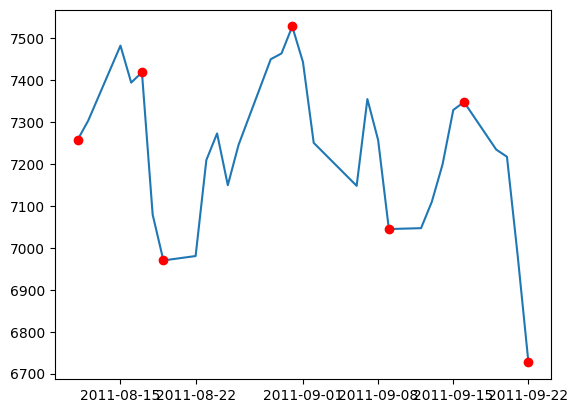

In [15]:
plt.plot(NYSE.index[1658:1688], NYSE.iloc[1658:1688])
plt.plot(NYSE.index[np.array((1658, 1662, 1664, 1672, 1678, 1683, 1687))], NYSE.iloc[np.array((1658, 1662, 1664, 1672, 1678, 1683, 1687))], 'ro')

In [13]:
pattern.bottom_hs_time

[(785, 795, 798, 800, 801, 802, 814)]

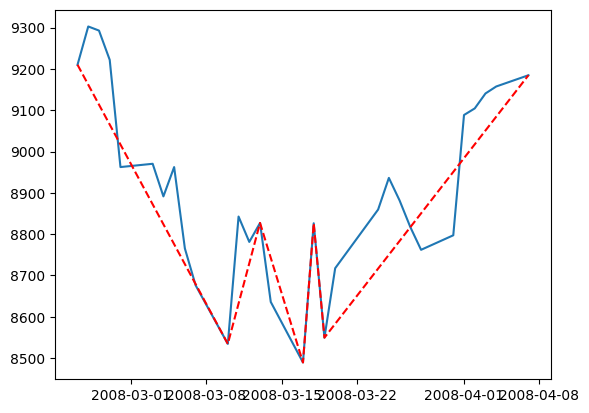

In [209]:
plt.plot(NYSE.index[785:815], NYSE.iloc[785:815])
plt.plot(NYSE.index[np.array((785, 795, 798, 800, 801, 802, 814))], NYSE.iloc[np.array((785, 795, 798, 800, 801, 802, 814))], 'r--')
plt.show()